# <font color='red'>**Sequence to sequence implementation**</font>

##   Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
 
    



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

<font color='blue'>**Load the data**</font>

In [426]:
with open('ita-eng/ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(353281, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [3]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

In [428]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [429]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


### Max number of words taking 22 as its at 99.9th percentile(Italian)

In [430]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


### Max number of words taking 25 as its at 99.9th percentile(English)

In [431]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 22]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 25]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [432]:
data.shape

(352878, 3)

In [434]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [435]:
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [436]:
train.head(2)

,italian,english_inp,english_out
38846,questa è la sua penna,<start> is this your pen <end>,is this your pen <end> <end>
1038,state fermi,<start> stay put,stay put <end>


In [437]:
validation.head(2)

,italian,english_inp,english_out
11683,loro sono alte,<start> are they tall,are they tall <end>
11815,gli uccelli possono volare,<start> birds can fly,birds can fly <end>


In [438]:
print(f"train.shape:{train.shape}")
print(f"validation.shape:{validation.shape}")

train.shape:(40000, 3)
validation.shape:(10000, 3)


In [4]:
import joblib
# joblib.dump(train, "train")
# joblib.dump(validation, "validation")
train = joblib.load("train")
validation = joblib.load("validation")

In [5]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [6]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13079
26681


In [7]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10289)

### Glove vectors for eng data

In [8]:
from tqdm import tqdm
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

hits, misses = 0, 0
embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tqdm(tknizer_eng.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

100%|████████████████████████████████████████████████████████████████████████| 13079/13079 [00:00<00:00, 345316.36it/s]

Converted 12834 words (245 misses)


### Data generator classes

In [9]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_eng, max_len_ita):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_eng = max_len_eng
        self.max_len_ita = max_len_ita

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [10]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 25, 22)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 25, 22)

train_dataloader = Dataloder(train_dataset, batch_size=128)
test_dataloader = Dataloder(test_dataset, batch_size=128)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(128, 22) (128, 25) (128, 25)




## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

### Encoder model inherited

In [232]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__(name="encode_model")
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size,input_length=self.input_length,\
                  mask_zero=True, name="embedding_layer_encoder")
        self.LSTM = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")


    def call(self,input_sequence,training=True):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embeddings = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.LSTM(input_embeddings)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        lstm_state_h = tf.zeros([batch_size, self.lstm_size])
        lstm_state_c = tf.zeros([batch_size, self.lstm_size])
      
        return lstm_state_h, lstm_state_c


### Decoder model inherited

In [75]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__(name="decode_model")
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size,input_length=self.input_length,\
                  mask_zero=True, weights=[embedding_matrix], trainable=False, name="embedding_layer_decoder")
        self.LSTM = LSTM(self.lstm_size, return_sequences=True, return_state=True, name="Dncoder_LSTM")
        

    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        state_h, state_c = initial_states[0], initial_states[1]
        input_embeddings = self.embedding(input_sequence)
        lstm_output, _, _  = self.LSTM(input_embeddings, initial_state=[state_h, state_c])
        return lstm_output, _, _


In [92]:
from tensorflow.keras.layers import TimeDistributed

### Encode_decoder model containing two inherited models Encode and Decoder

In [76]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,lstm_size,en_input_length,de_input_length):
        super().__init__(name="Encoder_Decoder_model")
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        
        
        self.encoder = Encoder(vocab_size_ita+1,embedding_size=50,lstm_size=lstm_size,input_length=en_input_length)
        self.decoder = Decoder(vocab_size_eng+1,embedding_size=100,lstm_size=lstm_size,input_length=de_input_length)
        self.dense   = Dense(vocab_size_eng+1, activation='softmax')
    def call(self, data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        
        input_italian, input_english = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input_italian)
        decoder_output , _, _                      = self.decoder(input_english, [encoder_h, encoder_c])
        output                               = self.dense(decoder_output)
        return output
        
        

### Compile and train

In [174]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime

filepath="model_save_non_attention/weights-{epoch:02d}-{val_loss:.2f}"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_format="tf", save_freq="epoch",  verbose=1, save_best_only=True, mode='auto')
           

In [175]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model = Encoder_decoder(256,22,25)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//96
valid_steps=validation.shape[0]//96
history = model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])
model.summary()

Epoch 1/20
2940/2940 [==============================] - ETA: 0s - loss: 0.2861
Epoch 1: val_loss improved from inf to 0.20945, saving model to model_save_non_attention\weights-01-0.21


INFO:tensorflow:Assets written to: model_save_non_attention\weights-01-0.21\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-01-0.21\assets


2940/2940 [==============================] - 125s 41ms/step - loss: 0.2861 - val_loss: 0.2095
Epoch 2/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.1727
Epoch 2: val_loss improved from 0.20945 to 0.14498, saving model to model_save_non_attention\weights-02-0.14


INFO:tensorflow:Assets written to: model_save_non_attention\weights-02-0.14\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-02-0.14\assets


2940/2940 [==============================] - 119s 41ms/step - loss: 0.1727 - val_loss: 0.1450
Epoch 3/20
2940/2940 [==============================] - ETA: 0s - loss: 0.1209
Epoch 3: val_loss improved from 0.14498 to 0.10975, saving model to model_save_non_attention\weights-03-0.11


INFO:tensorflow:Assets written to: model_save_non_attention\weights-03-0.11\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-03-0.11\assets


2940/2940 [==============================] - 121s 41ms/step - loss: 0.1209 - val_loss: 0.1098
Epoch 4/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0899
Epoch 4: val_loss improved from 0.10975 to 0.08968, saving model to model_save_non_attention\weights-04-0.09


INFO:tensorflow:Assets written to: model_save_non_attention\weights-04-0.09\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-04-0.09\assets


2940/2940 [==============================] - 120s 41ms/step - loss: 0.0899 - val_loss: 0.0897
Epoch 5/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0706
Epoch 5: val_loss improved from 0.08968 to 0.07709, saving model to model_save_non_attention\weights-05-0.08


INFO:tensorflow:Assets written to: model_save_non_attention\weights-05-0.08\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-05-0.08\assets


2940/2940 [==============================] - 121s 41ms/step - loss: 0.0706 - val_loss: 0.0771
Epoch 6/20
2938/2940 [============================>.] - ETA: 0s - loss: 0.0577
Epoch 6: val_loss improved from 0.07709 to 0.06918, saving model to model_save_non_attention\weights-06-0.07


INFO:tensorflow:Assets written to: model_save_non_attention\weights-06-0.07\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-06-0.07\assets


2940/2940 [==============================] - 119s 41ms/step - loss: 0.0577 - val_loss: 0.0692
Epoch 7/20
2940/2940 [==============================] - ETA: 0s - loss: 0.0486
Epoch 7: val_loss improved from 0.06918 to 0.06375, saving model to model_save_non_attention\weights-07-0.06


INFO:tensorflow:Assets written to: model_save_non_attention\weights-07-0.06\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-07-0.06\assets


2940/2940 [==============================] - 119s 40ms/step - loss: 0.0486 - val_loss: 0.0638
Epoch 8/20
2940/2940 [==============================] - ETA: 0s - loss: 0.0418
Epoch 8: val_loss improved from 0.06375 to 0.05959, saving model to model_save_non_attention\weights-08-0.06


INFO:tensorflow:Assets written to: model_save_non_attention\weights-08-0.06\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-08-0.06\assets


2940/2940 [==============================] - 121s 41ms/step - loss: 0.0418 - val_loss: 0.0596
Epoch 9/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0366
Epoch 9: val_loss improved from 0.05959 to 0.05657, saving model to model_save_non_attention\weights-09-0.06


INFO:tensorflow:Assets written to: model_save_non_attention\weights-09-0.06\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-09-0.06\assets


2940/2940 [==============================] - 118s 40ms/step - loss: 0.0366 - val_loss: 0.0566
Epoch 10/20
2940/2940 [==============================] - ETA: 0s - loss: 0.0324
Epoch 10: val_loss improved from 0.05657 to 0.05498, saving model to model_save_non_attention\weights-10-0.05


INFO:tensorflow:Assets written to: model_save_non_attention\weights-10-0.05\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-10-0.05\assets


2940/2940 [==============================] - 121s 41ms/step - loss: 0.0324 - val_loss: 0.0550
Epoch 11/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0290
Epoch 11: val_loss improved from 0.05498 to 0.05329, saving model to model_save_non_attention\weights-11-0.05


INFO:tensorflow:Assets written to: model_save_non_attention\weights-11-0.05\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-11-0.05\assets


2940/2940 [==============================] - 120s 41ms/step - loss: 0.0290 - val_loss: 0.0533
Epoch 12/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0262
Epoch 12: val_loss improved from 0.05329 to 0.05264, saving model to model_save_non_attention\weights-12-0.05


INFO:tensorflow:Assets written to: model_save_non_attention\weights-12-0.05\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-12-0.05\assets


2940/2940 [==============================] - 118s 40ms/step - loss: 0.0262 - val_loss: 0.0526
Epoch 13/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0239
Epoch 13: val_loss improved from 0.05264 to 0.05154, saving model to model_save_non_attention\weights-13-0.05


INFO:tensorflow:Assets written to: model_save_non_attention\weights-13-0.05\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-13-0.05\assets


2940/2940 [==============================] - 121s 41ms/step - loss: 0.0239 - val_loss: 0.0515
Epoch 14/20
2940/2940 [==============================] - ETA: 0s - loss: 0.0218
Epoch 14: val_loss improved from 0.05154 to 0.05129, saving model to model_save_non_attention\weights-14-0.05


INFO:tensorflow:Assets written to: model_save_non_attention\weights-14-0.05\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-14-0.05\assets


2940/2940 [==============================] - 118s 40ms/step - loss: 0.0218 - val_loss: 0.0513
Epoch 15/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0201
Epoch 15: val_loss improved from 0.05129 to 0.05061, saving model to model_save_non_attention\weights-15-0.05


INFO:tensorflow:Assets written to: model_save_non_attention\weights-15-0.05\assets


INFO:tensorflow:Assets written to: model_save_non_attention\weights-15-0.05\assets


2940/2940 [==============================] - 121s 41ms/step - loss: 0.0201 - val_loss: 0.0506
Epoch 16/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0186
Epoch 16: val_loss did not improve from 0.05061
2940/2940 [==============================] - 106s 36ms/step - loss: 0.0186 - val_loss: 0.0510
Epoch 17/20
2940/2940 [==============================] - ETA: 0s - loss: 0.0172
Epoch 17: val_loss did not improve from 0.05061
2940/2940 [==============================] - 105s 36ms/step - loss: 0.0172 - val_loss: 0.0508
Epoch 18/20
2939/2940 [============================>.] - ETA: 0s - loss: 0.0160
Epoch 18: val_loss did not improve from 0.05061
2940/2940 [==============================] - 105s 36ms/step - loss: 0.0160 - val_loss: 0.0511
Epoch 19/20
2938/2940 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 19: val_loss did not improve from 0.05061
2940/2940 [==============================] - 105s 36ms/step - loss: 0.0150 - val_loss: 0.0511
Epoch 20/20
2939/2

## BEST loss: 0.0512 in 20 epochs

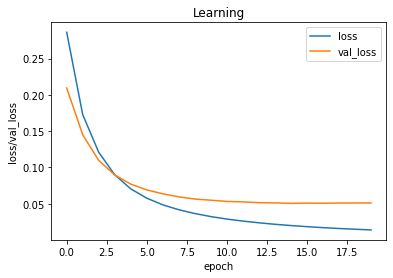

In [177]:
loss = history.history['loss']
# acc = history.history['acc']
val_loss = history.history['val_loss'] 
epoch = 20
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
plt.legend()


In [178]:
# model.save('model',save_format='tf')
# loaded_model = tf.keras.models.load_model('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [36]:
italian_dict = {v:k for k,v in tknizer_ita.word_index.items()}
english_dict = {v:k for k,v in tknizer_eng.word_index.items()}

In [119]:
# joblib.dump(italian_dict, "italian_dict")
# joblib.dump(english_dict, "english_dict")

['english_dict']

### Prediction

In [ ]:
joblib.load("english_dict")

In [260]:
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    ENCODER_SEQ_LEN = 22
    DECODER_SEQ_LEN = 25
    loaded_model = model
#     print("=" * 30, "Inference", "=" * 30)
    
    nums = tknizer_ita.texts_to_sequences([input_sentence])
    nums_padded = pad_sequences(nums, maxlen=max_len_ita, dtype='int32', padding='post')
 
    encoder_output, enc_state_h, enc_state_c = loaded_model.layers[0](nums_padded)
    pred, alphas = [], []
     
    states_values = [enc_state_h, enc_state_c]
    pred = []
    cur_vec = np.zeros((1, 1))
#     print('-'*20,"started predition","-"*20) 
    for i in range(DECODER_SEQ_LEN):
        cur_emb = loaded_model.layers[1].embedding(cur_vec)
        infe_output, state_h, state_c = loaded_model.layers[1].LSTM(cur_emb, initial_state=states_values)
        infe_output=loaded_model.layers[2](infe_output)
        states_values = [state_h, state_c]
        # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
        # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        print(f"at time step {i} the word is ", cur_vec)
        
        if english_dict[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec)
 

    pred_string = " ".join([ english_dict[i[0][0]] for i in pred])
    
    print("PREDICTED STRING:",pred_string) 
    
    return  input_sentence, pred_string
    

In [266]:
index = 200
input_test_sentence = validation["italian"].values[index]
actual = validation["english_out"].values[index]
input_sentence, pred_string = predict(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {pred_string}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

at time step 0 the word is  [[3363]]
at time step 1 the word is  [[11]]
at time step 2 the word is  [[8]]
at time step 3 the word is  [[193]]
at time step 4 the word is  [[4]]
at time step 5 the word is  [[6]]
at time step 6 the word is  [[10289]]
PREDICTED STRING: steady are the father tom is
Input_sentence: è il padre di tom
English predict: steady are the father tom is
English actual: that is tom is father


### BLUE score

In [218]:
 
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[30:60]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[30:60]
for i in range(30):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict(input_test_sentence)
    print(f"ACTUAL STRING: {test_eng[i]}")
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    print(f'BL880EU score: {colored(bs, "green", attrs=["bold"]) if 0.5<=bs<=1 else colored(round(bs, 2), "red", attrs=["bold"])}')
    print("="*80)

============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady are you a teacher
ACTUAL STRING: you are a teacher
BL880EU score: 0.0
============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady do not you what would he
ACTUAL STRING: are not you going to eat it
BL880EU score: 0.0
============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady i would like to drastically decrease than the amount of the way where i take it off the rest
ACTUAL STRING: i would like to drastically decrease the amount of time it takes me to clean the house
BL880EU score: 0.32
============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady 

PREDICTED STRING: steady my uncle lived a beautiful father and a strong body died
ACTUAL STRING: my uncle lived a happy life and died a peaceful death
BL880EU score: 0.24
============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady have a lot of books two hours
ACTUAL STRING: i have a lot more books than you do
BL880EU score: 0.0
============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady still are not you sure
ACTUAL STRING: we are still not sure
BL880EU score: 0.0
============================== Inference ==============================
-------------------- started predition --------------------
PREDICTED STRING: steady students did completely any rice
ACTUAL STRING: the students all laughed
BL880EU score: 0.0
============================== Inference ==============================
---------------

In [221]:
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[:1000]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[:1000]
bss = []
for i in tqdm(range(1000)):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict(input_test_sentence)
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    bss.append(bs)


    


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.69it/s]


## AVG. BLUE score

In [222]:
np.mean(bss)

0.1781403652170443

# -----ATTENTION MODELS-----

# MODEL-1 DOT SCORE 

##  Including Attention mechanisum

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

### Encoder model inherited

In [11]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__(name="encode_model_Attention")
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size,input_length=self.input_length,\
                  mask_zero=True, name="embedding_layer_encoder")
        self.LSTM = LSTM(self.lstm_size, return_state=True, return_sequences=True, \
                          name="Encoder_LSTM")

    def call(self,input_sequence):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embeddings = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.LSTM(input_embeddings)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        lstm_state_h = tf.zeros([batch_size, self.lstm_size])
        lstm_state_c = tf.zeros([batch_size, self.lstm_size])

        return lstm_state_h, lstm_state_c




<font color='blue'>**Attention**</font>

 ### Attention layer interited

In [14]:
from tensorflow.keras.layers import *
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):

        super().__init__(name="Attention")
        # Please go through the reference notebook and research paper to complete the scoring functions
        self.scoring_function = scoring_function
        self.att_units = att_units
        if self.scoring_function=='dot':
          # Intialize variables needed for Dot score function here
          pass
        if scoring_function == 'general':
          # Intialize variables needed for General score function here
            self.dense = Dense(self.att_units, activation='relu')
        elif scoring_function == 'concat':
          # Intialize variables needed for Concat score function here
      
            self.K = 100
            self.dense_1 = Dense(self.K, activation='relu')
            self.dense_2 = Dense(self.K, activation='relu')
            self.dense_3 = Dense(1, activation='relu')
  

    def call(self,decoder_hidden_state,encoder_output):
        '''
          Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
          * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''

        if self.scoring_function == 'dot':
            # Implement Dot score function here 
            ei = tf.keras.layers.Dot(axes = (-1,-1))([decoder_hidden_state, encoder_output])
            alphas = Softmax()(ei)
            alphas = tf.expand_dims(alphas, axis=-1)
            mull = tf.keras.layers.Multiply()([encoder_output, alphas])
            context_vec = tf.reduce_mean(mull, axis=-2)
            return context_vec, alphas
        elif self.scoring_function == 'general':
            # Implement General score function here
            encoder_output_shrinked = self.dense(encoder_output)
            ei = tf.keras.layers.Dot(axes = (-1,-1))([decoder_hidden_state, encoder_output_shrinked])
            alphas = Softmax()(ei)
            alphas = tf.expand_dims(alphas, axis=-1)
            mull = tf.keras.layers.Multiply()([encoder_output, alphas])
            context_vec = tf.reduce_mean(mull, axis=-2)
            return context_vec, alphas
            
            
        elif self.scoring_function == 'concat':
            
            k1 = self.dense_1(encoder_output)
            k2 =  self.dense_2(decoder_hidden_state)
            add = tf.keras.layers.Add()([k1, k2])
            tanh = tf.keras.layers.Activation(activation="tanh")(add)
            ei = self.dense_3(tanh)
            ei = tf.squeeze(ei,-1)
            alphas = Softmax()(ei) 
            alphas = tf.expand_dims(alphas, axis=-1)
            mull = tf.keras.layers.Multiply()([encoder_output, alphas])
            context_vec = tf.reduce_mean(mull, axis=-2)                
            return context_vec, alphas
    
  #!@  

In [13]:
vocab_size_ita

26681

### Attention Decoder Main component -- One step ecoder inhertited from Model class

In [15]:
class OneStepDecoder(tf.keras.Model):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__(name="OneStepDecoder")
        # Initialize decoder embedding layer, LSTM and any other objects needed
        
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.attention = Attention(score_fun,att_units)
        self.embedding = Embedding(input_dim = tar_vocab_size, output_dim = embedding_dim, input_length = input_length, mask_zero=True,\
                weights=[embedding_matrix], trainable=False )
        
        self.lstm = LSTM(self.dec_units, \
                         return_sequences=True, return_state=True, \
                          name="OneStepDecoder_LSTM")
        self.bn = BatchNormalization()
        self.dense = Dense(tar_vocab_size, activation='softmax')
        

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
             One step decoder mechanisim step by step:
          A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
          B. Using the encoder_output and decoder hidden state, compute the context vector.
          C. Concat the context vector with the step A output
          D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
          E. Pass the decoder output to dense layer(vocab size) and store the result into output.
          F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        #adding attention information to embeddings now
        embeddings = self.embedding(input_to_decoder)
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        attention_embeddings = tf.concat([tf.expand_dims(context_vector, 1), embeddings], axis=-1)
        
        x, state_h, state_c = self.lstm(attention_embeddings, initial_state=[state_h, state_c])
        
        output = self.dense(x)
        output = self.bn(output)
        output = tf.squeeze(output,1)
        return output, state_h, state_c, attention_weights, context_vector
        
        

<font color='blue'>**Decoder**</font>

### Decoder used for calling OneStepDecoder Model for each english word(num form) inherited from Model

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__(name="Decode_Attention")
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun 
        self.att_units = att_units
        self.onestepdecoder = OneStepDecoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs = tf.TensorArray(tf.float32, size=25, name="output_arrays")
        for timestep in range(25):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector = self.onestepdecoder(\
                                input_to_decoder[:, timestep:timestep+1],encoder_output,\
                                decoder_hidden_state,decoder_cell_state
                               )
            
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs
    

<font color='blue'>**Encoder Decoder model**</font>

### Final encoder_deocder inherited Model
* Take italian language for all timestep and preserves each LSTM layer hidden state an final cell state=>Encoder Model,
  We stop its execution for input 1(or batch), from now onwards **DECODER** will take care

* Decoder consumes ENCODER's returned values and pass it to ONESTEPDECODER (its backbone)
* ONESTEPDECODER will use encoder's output given to it by DECODER and will calculate summary of Encoders each timestep hidden
  state by giving more importance to a word which is more responsible to predict the upcoming predicted word those importance
  is nothing but **ATTENTIONS** should given to each input Italian word
* Then ONESTEPDECODER consumes that weighted summary and concatenate with input english word at the timestep only and
  pass it to LSTM and then dense layer gives us the num value of the predict word.
  - This is done for each timestep and DECODER is responsible for one by one calling for each word

**ENCODER** **=>** [ **DECODER**=>loop**(** **ONESTEPDECODER**=>Attention+LSTM+dense**)** ] **=>** List of integers representing predicted sentence

In [17]:
class encoder_decoder(tf.keras.Model):
    def __init__(self,inp_vocab_size, out_vocab_size, en_input_length,de_input_length, dec_units ,score_fun ,att_units):
    #Intialize objects from encoder decoder
        super().__init__(name="Encoder_Decoder_Attention_model")
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        

         
        
        self.encoder = Encoder(inp_vocab_size, 50,dec_units, en_input_length)
        self.decoder = Decoder(out_vocab_size, 100, de_input_length, dec_units, score_fun, att_units)
#         self.dense   = Dense(vocab_size_eng+1, activation='softmax')
                             
    def call(self,data):
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        input_italian, input_english = data[0], data[1]
        encoder_output, encoder_h, encoder_c = self.encoder(input_italian)
        decoder_output = self.decoder(input_english,encoder_output, encoder_h, encoder_c)
        return decoder_output
        





<font color='blue'>**Custom loss function**</font>

In [18]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    can use simple sparse categorical crossentropy as loss like we did . But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [51]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime

filepath="model_save_attention_general/weights-{epoch:02d}-{val_loss:.2f}"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_format="tf", save_freq="epoch",  verbose=1, save_best_only=True, mode='auto')
           

In [20]:
from keras.regularizers import l2

In [21]:
import warnings
warnings.filterwarnings("ignore")

### for 20 epochs

In [22]:


model_attention_dot = encoder_decoder(vocab_size_ita+1,vocab_size_eng+1,22,25,512,"dot",512)
optimizer = tf.keras.optimizers.Adam()
model_attention_dot.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_dot = model_attention_dot.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


Epoch 1/20
2205/2205 [==============================] - ETA: 0s - loss: 1.5499
Epoch 1: val_loss improved from inf to 1.20464, saving model to model_save_attention_dot\weights-01-1.20


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-01-1.20\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-01-1.20\assets


2205/2205 [==============================] - 457s 194ms/step - loss: 1.5499 - val_loss: 1.2046
Epoch 2/20
2205/2205 [==============================] - ETA: 0s - loss: 0.9016
Epoch 2: val_loss improved from 1.20464 to 0.98323, saving model to model_save_attention_dot\weights-02-0.98


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-02-0.98\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-02-0.98\assets


2205/2205 [==============================] - 424s 192ms/step - loss: 0.9016 - val_loss: 0.9832
Epoch 3/20
2205/2205 [==============================] - ETA: 0s - loss: 0.7428
Epoch 3: val_loss improved from 0.98323 to 0.82875, saving model to model_save_attention_dot\weights-03-0.83


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-03-0.83\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-03-0.83\assets


2205/2205 [==============================] - 412s 187ms/step - loss: 0.7428 - val_loss: 0.8287
Epoch 4/20
2205/2205 [==============================] - ETA: 0s - loss: 0.6496
Epoch 4: val_loss improved from 0.82875 to 0.75238, saving model to model_save_attention_dot\weights-04-0.75


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-04-0.75\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-04-0.75\assets


2205/2205 [==============================] - 411s 187ms/step - loss: 0.6496 - val_loss: 0.7524
Epoch 5/20
2205/2205 [==============================] - ETA: 0s - loss: 0.5892
Epoch 5: val_loss improved from 0.75238 to 0.69024, saving model to model_save_attention_dot\weights-05-0.69


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-05-0.69\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-05-0.69\assets


2205/2205 [==============================] - 412s 187ms/step - loss: 0.5892 - val_loss: 0.6902
Epoch 6/20
2205/2205 [==============================] - ETA: 0s - loss: 0.5411
Epoch 6: val_loss improved from 0.69024 to 0.66872, saving model to model_save_attention_dot\weights-06-0.67


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-06-0.67\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-06-0.67\assets


2205/2205 [==============================] - 414s 188ms/step - loss: 0.5411 - val_loss: 0.6687
Epoch 7/20
2205/2205 [==============================] - ETA: 0s - loss: 0.5022
Epoch 7: val_loss improved from 0.66872 to 0.62590, saving model to model_save_attention_dot\weights-07-0.63


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-07-0.63\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-07-0.63\assets


2205/2205 [==============================] - 415s 188ms/step - loss: 0.5022 - val_loss: 0.6259
Epoch 8/20
2205/2205 [==============================] - ETA: 0s - loss: 0.4682
Epoch 8: val_loss improved from 0.62590 to 0.60602, saving model to model_save_attention_dot\weights-08-0.61


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-08-0.61\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-08-0.61\assets


2205/2205 [==============================] - 416s 188ms/step - loss: 0.4682 - val_loss: 0.6060
Epoch 9/20
2205/2205 [==============================] - ETA: 0s - loss: 0.4388
Epoch 9: val_loss improved from 0.60602 to 0.58371, saving model to model_save_attention_dot\weights-09-0.58


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-09-0.58\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-09-0.58\assets


2205/2205 [==============================] - 414s 188ms/step - loss: 0.4388 - val_loss: 0.5837
Epoch 10/20
2205/2205 [==============================] - ETA: 0s - loss: 0.4128
Epoch 10: val_loss improved from 0.58371 to 0.57495, saving model to model_save_attention_dot\weights-10-0.57


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-10-0.57\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-10-0.57\assets


2205/2205 [==============================] - 423s 192ms/step - loss: 0.4128 - val_loss: 0.5750
Epoch 11/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3919
Epoch 11: val_loss improved from 0.57495 to 0.54921, saving model to model_save_attention_dot\weights-11-0.55


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-11-0.55\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-11-0.55\assets


2205/2205 [==============================] - 418s 190ms/step - loss: 0.3919 - val_loss: 0.5492
Epoch 12/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3748
Epoch 12: val_loss improved from 0.54921 to 0.54819, saving model to model_save_attention_dot\weights-12-0.55


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-12-0.55\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-12-0.55\assets


2205/2205 [==============================] - 414s 188ms/step - loss: 0.3748 - val_loss: 0.5482
Epoch 13/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3590
Epoch 13: val_loss improved from 0.54819 to 0.53792, saving model to model_save_attention_dot\weights-13-0.54


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-13-0.54\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-13-0.54\assets


2205/2205 [==============================] - 417s 189ms/step - loss: 0.3590 - val_loss: 0.5379
Epoch 14/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3464
Epoch 14: val_loss did not improve from 0.53792
2205/2205 [==============================] - 379s 172ms/step - loss: 0.3464 - val_loss: 0.5472
Epoch 15/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3342
Epoch 15: val_loss improved from 0.53792 to 0.52334, saving model to model_save_attention_dot\weights-15-0.52


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-15-0.52\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-15-0.52\assets


2205/2205 [==============================] - 415s 188ms/step - loss: 0.3342 - val_loss: 0.5233
Epoch 16/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3239
Epoch 16: val_loss did not improve from 0.52334
2205/2205 [==============================] - 379s 172ms/step - loss: 0.3239 - val_loss: 0.5241
Epoch 17/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3149
Epoch 17: val_loss improved from 0.52334 to 0.51652, saving model to model_save_attention_dot\weights-17-0.52


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-17-0.52\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-17-0.52\assets


2205/2205 [==============================] - 415s 188ms/step - loss: 0.3149 - val_loss: 0.5165
Epoch 18/20
2205/2205 [==============================] - ETA: 0s - loss: 0.3063
Epoch 18: val_loss improved from 0.51652 to 0.51191, saving model to model_save_attention_dot\weights-18-0.51


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-18-0.51\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-18-0.51\assets


2205/2205 [==============================] - 416s 189ms/step - loss: 0.3063 - val_loss: 0.5119
Epoch 19/20
2205/2205 [==============================] - ETA: 0s - loss: 0.2978
Epoch 19: val_loss did not improve from 0.51191
2205/2205 [==============================] - 379s 172ms/step - loss: 0.2978 - val_loss: 0.5127
Epoch 20/20
2205/2205 [==============================] - ETA: 0s - loss: 0.2900
Epoch 20: val_loss improved from 0.51191 to 0.50012, saving model to model_save_attention_dot\weights-20-0.50


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-20-0.50\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-20-0.50\assets


2205/2205 [==============================] - 417s 189ms/step - loss: 0.2900 - val_loss: 0.5001


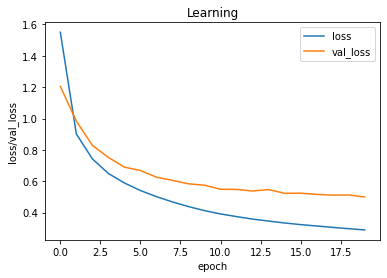

In [26]:
loss = history_dot.history['loss']
# acc = history.history['acc']
val_loss = history_dot.history['val_loss'] 
epoch = 20
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss") 
plt.legend()


### Training more for 10 EPOCHS more!

In [27]:

# model_attention = encoder_decoder(vocab_size_ita+1,vocab_size_eng+1,22,25,256,"dot",256)
# optimizer = tf.keras.optimizers.Adam()
# model_attention.compile(optimizer=optimizer,loss=loss_function)
# train_steps=train.shape[0]//96
# valid_steps=validation.shape[0]//96
history_dot_2 = model_attention_dot.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


Epoch 1/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1871
Epoch 1: val_loss did not improve from 0.47269
2205/2205 [==============================] - 386s 175ms/step - loss: 0.1871 - val_loss: 0.4768
Epoch 2/10
1324/2205 [=================>............] - ETA: 2:21 - loss: 0.1847

KeyboardInterrupt: 

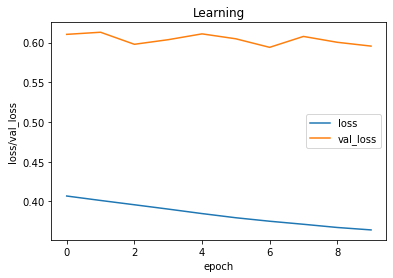

In [32]:
loss = history_dot_2.history['loss']
val_loss = history_dot_2.history['val_loss']
epoch = 10
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
plt.legend()


### for 10 epochs more!

In [24]:
history_dot_3 = model_attention_dot.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])

Epoch 1/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2348
Epoch 1: val_loss improved from 0.48636 to 0.48419, saving model to model_save_attention_dot\weights-01-0.48


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-01-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-01-0.48\assets


2205/2205 [==============================] - 447s 203ms/step - loss: 0.2348 - val_loss: 0.4842
Epoch 2/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2315
Epoch 2: val_loss did not improve from 0.48419
2205/2205 [==============================] - 385s 175ms/step - loss: 0.2315 - val_loss: 0.4883
Epoch 3/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2281
Epoch 3: val_loss did not improve from 0.48419
2205/2205 [==============================] - 403s 183ms/step - loss: 0.2281 - val_loss: 0.4900
Epoch 4/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2246
Epoch 4: val_loss did not improve from 0.48419
2205/2205 [==============================] - 405s 184ms/step - loss: 0.2246 - val_loss: 0.4922
Epoch 5/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2221
Epoch 5: val_loss improved from 0.48419 to 0.48343, saving model to model_save_attention_dot\weights-05-0.48


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-05-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-05-0.48\assets


2205/2205 [==============================] - 434s 197ms/step - loss: 0.2221 - val_loss: 0.4834
Epoch 6/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2190
Epoch 6: val_loss did not improve from 0.48343
2205/2205 [==============================] - 399s 181ms/step - loss: 0.2190 - val_loss: 0.4841
Epoch 7/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2161
Epoch 7: val_loss improved from 0.48343 to 0.47757, saving model to model_save_attention_dot\weights-07-0.48


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-07-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-07-0.48\assets


2205/2205 [==============================] - 517s 235ms/step - loss: 0.2161 - val_loss: 0.4776
Epoch 8/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2137
Epoch 8: val_loss did not improve from 0.47757
2205/2205 [==============================] - 402s 182ms/step - loss: 0.2137 - val_loss: 0.4784
Epoch 9/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2113
Epoch 9: val_loss did not improve from 0.47757
2205/2205 [==============================] - 392s 178ms/step - loss: 0.2113 - val_loss: 0.4861
Epoch 10/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2090
Epoch 10: val_loss did not improve from 0.47757
2205/2205 [==============================] - 398s 180ms/step - loss: 0.2090 - val_loss: 0.4806


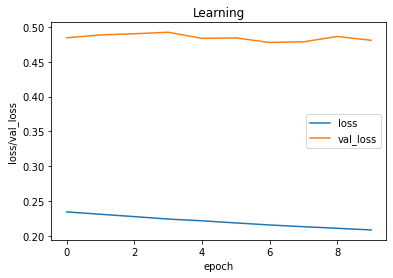

In [28]:
loss = history_dot_3.history['loss'] 
val_loss = history_dot_3.history['val_loss'] 
epoch = 10
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss") 
plt.legend()


### for 10 epochs more!

In [25]:
history_dot_4 = model_attention_dot.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])

Epoch 1/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2065
Epoch 1: val_loss did not improve from 0.47757
2205/2205 [==============================] - 408s 185ms/step - loss: 0.2065 - val_loss: 0.4807
Epoch 2/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2040
Epoch 2: val_loss did not improve from 0.47757
2205/2205 [==============================] - 383s 174ms/step - loss: 0.2040 - val_loss: 0.4840
Epoch 3/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2017
Epoch 3: val_loss did not improve from 0.47757
2205/2205 [==============================] - 392s 178ms/step - loss: 0.2017 - val_loss: 0.4850
Epoch 4/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1999
Epoch 4: val_loss did not improve from 0.47757
2205/2205 [==============================] - 392s 178ms/step - loss: 0.1999 - val_loss: 0.4810
Epoch 5/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1975
Epoch 5: val_loss improved from 0.477

INFO:tensorflow:Assets written to: model_save_attention_dot\weights-05-0.47\assets


INFO:tensorflow:Assets written to: model_save_attention_dot\weights-05-0.47\assets


2205/2205 [==============================] - 431s 195ms/step - loss: 0.1975 - val_loss: 0.4727
Epoch 6/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1959
Epoch 6: val_loss did not improve from 0.47269
2205/2205 [==============================] - 413s 187ms/step - loss: 0.1959 - val_loss: 0.4774
Epoch 7/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1939
Epoch 7: val_loss did not improve from 0.47269
2205/2205 [==============================] - 407s 184ms/step - loss: 0.1939 - val_loss: 0.4791
Epoch 8/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1923
Epoch 8: val_loss did not improve from 0.47269
2205/2205 [==============================] - 425s 193ms/step - loss: 0.1923 - val_loss: 0.4820
Epoch 9/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1905
Epoch 9: val_loss did not improve from 0.47269
2205/2205 [==============================] - 383s 174ms/step - loss: 0.1905 - val_loss: 0.4760
Epoch 10/10
2205/2205

## BEST Loss:0.47 in 50 EPOCHS

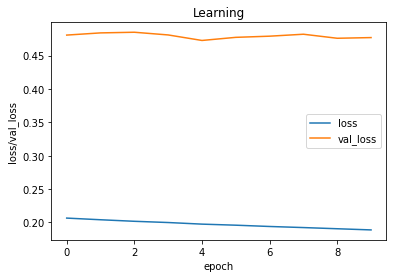

In [29]:
loss = history_dot_4.history['loss'] 
val_loss = history_dot_4.history['val_loss'] 
epoch = 10
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss") 
plt.legend()

In [30]:
model_attention_dot.summary()

Model: "Encoder_Decoder_Attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_model_Attention (Enc  multiple                 2487124   
 oder)                                                           
                                                                 
 Decode_Attention (Decoder)  multiple                  10374360  
                                                                 
Total params: 12,861,484
Trainable params: 11,527,324
Non-trainable params: 1,334,160
_________________________________________________________________


In [43]:
max_len_ita = 22

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



    plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [47]:
def predict_dot(input_test_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    ENCODER_SEQ_LEN = 22
    DECODER_SEQ_LEN = 25
    max_len_ita = 22
    nums = tknizer_ita.texts_to_sequences([input_test_sentence])
    nums_padded = pad_sequences(nums, maxlen=max_len_ita, dtype='int32', padding='post')
    encoder_output, enc_state_h, enc_state_c = model_attention_dot.layers[0](nums_padded)
    pred, alphas = [], []
    cur_vec = np.zeros((1, 1))
    osd = model_attention_dot.layers[1].onestepdecoder
    for i in range(DECODER_SEQ_LEN):
        
        
        output, state_h, state_c, attention_weights, context_vector = osd(cur_vec, encoder_output, enc_state_h, enc_state_c )
        
        enc_state_h, enc_state_c = state_h, state_c
        alphas.append(attention_weights.numpy().flatten())
        
        
        cur_vec = np.reshape(np.argmax(output), (1, 1))
        print(f"at time step {i} the word is ", cur_vec)
        
        if english_dict[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec)
        
        
     
    pred_string = ""

    pred_string = " ".join([ english_dict[i[0][0]] for i in pred])
    
    print("PREDICTED STRING:",pred_string)
    
   
    
    plot_attention(alphas, input_test_sentence, pred_string)
    
    return  input_test_sentence, pred_string
    
            
        
    
    
    

at time step 0 the word is  [[4]]
at time step 1 the word is  [[618]]
at time step 2 the word is  [[9]]
at time step 3 the word is  [[2381]]
at time step 4 the word is  [[10289]]
PREDICTED STRING: tom needed a fuji


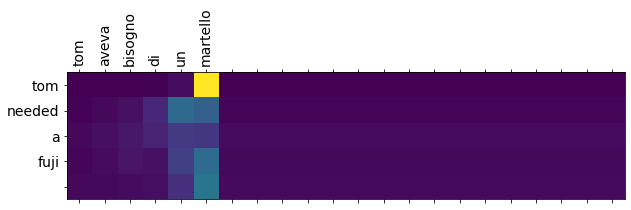

Input_sentence: tom aveva bisogno di un martello
English predict: tom needed a fuji
English actual: tom needed a hammer


In [40]:
index = 2010
input_test_sentence = validation["italian"].values[index]
actual = validation["english_out"].values[index]
input_sentence, pred_string = predict_dot(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {pred_string}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

In [41]:
 from termcolor import colored

<font color='blue'>**Calculate BLEU score**</font>

In [45]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[30:60]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[30:60]
for i in range(30):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict_dot(input_test_sentence)
    print(f"ACTUAL STRING: {test_eng[i]}")
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    print(f'BL880EU score: {colored(bs, "green", attrs=["bold"]) if 0.5<=bs<=1 else colored(round(bs, 2), "red", attrs=["bold"])}')
    print("="*80)

PREDICTED STRING: she is a prude
ACTUAL STRING: you are a teacher
BL880EU score: 0.0
PREDICTED STRING: are not you going to eat it
ACTUAL STRING: are not you going to eat it
BL880EU score: 1.0
PREDICTED STRING: i would like to clean the cold time that time takes me to waste the house
ACTUAL STRING: i would like to drastically decrease the amount of time it takes me to clean the house
BL880EU score: 0.29
PREDICTED STRING: i think you are selfish
ACTUAL STRING: i think you are selfish
BL880EU score: 1.0
PREDICTED STRING: it will be fun to have somebody to play with
ACTUAL STRING: it will be fun to have somebody to play with
BL880EU score: 1.0
PREDICTED STRING: tell tom that i do not care
ACTUAL STRING: tell tom i do not care
BL880EU score: 0.49
PREDICTED STRING: pick up his clothes
ACTUAL STRING: pick your toys up
BL880EU score: 0.0
PREDICTED STRING: tom is not interested
ACTUAL STRING: tom is not interested
BL880EU score: 1.0
PREDICTED STRING: tom and mary are not canadian
ACTUAL STRING

In [48]:
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[:1000]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[:1000]
bss = []
for i in tqdm(range(1000)):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict_dot(input_test_sentence)
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    bss.append(bs)


    


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:57<00:00, 17.26it/s]


# AVG. BLUE score : 0.498

In [49]:
np.mean(bss)

0.49806404774972274

# MODEL-2 with general score

<font color='blue'>**Repeat the same steps for General scoring function**</font>

### For 30 epochs

In [52]:
 

model_attention_general = encoder_decoder(vocab_size_ita+1,vocab_size_eng+1,22,25,512,"general",512)
optimizer = tf.keras.optimizers.Adam()
model_attention_general.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_gen = model_attention_general.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


Epoch 1/30
2205/2205 [==============================] - ETA: 0s - loss: 1.5497
Epoch 1: val_loss improved from inf to 1.21391, saving model to model_save_attention_general\weights-01-1.21


INFO:tensorflow:Assets written to: model_save_attention_general\weights-01-1.21\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-01-1.21\assets


2205/2205 [==============================] - 527s 224ms/step - loss: 1.5497 - val_loss: 1.2139
Epoch 2/30
2205/2205 [==============================] - ETA: 0s - loss: 0.8961
Epoch 2: val_loss improved from 1.21391 to 0.96842, saving model to model_save_attention_general\weights-02-0.97


INFO:tensorflow:Assets written to: model_save_attention_general\weights-02-0.97\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-02-0.97\assets


2205/2205 [==============================] - 492s 223ms/step - loss: 0.8961 - val_loss: 0.9684
Epoch 3/30
2205/2205 [==============================] - ETA: 0s - loss: 0.7303
Epoch 3: val_loss improved from 0.96842 to 0.82565, saving model to model_save_attention_general\weights-03-0.83


INFO:tensorflow:Assets written to: model_save_attention_general\weights-03-0.83\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-03-0.83\assets


2205/2205 [==============================] - 499s 226ms/step - loss: 0.7303 - val_loss: 0.8256
Epoch 4/30
2205/2205 [==============================] - ETA: 0s - loss: 0.6382
Epoch 4: val_loss improved from 0.82565 to 0.74394, saving model to model_save_attention_general\weights-04-0.74


INFO:tensorflow:Assets written to: model_save_attention_general\weights-04-0.74\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-04-0.74\assets


2205/2205 [==============================] - 495s 225ms/step - loss: 0.6382 - val_loss: 0.7439
Epoch 5/30
2205/2205 [==============================] - ETA: 0s - loss: 0.5743
Epoch 5: val_loss improved from 0.74394 to 0.68864, saving model to model_save_attention_general\weights-05-0.69


INFO:tensorflow:Assets written to: model_save_attention_general\weights-05-0.69\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-05-0.69\assets


2205/2205 [==============================] - 492s 223ms/step - loss: 0.5743 - val_loss: 0.6886
Epoch 6/30
2205/2205 [==============================] - ETA: 0s - loss: 0.5266
Epoch 6: val_loss improved from 0.68864 to 0.65106, saving model to model_save_attention_general\weights-06-0.65


INFO:tensorflow:Assets written to: model_save_attention_general\weights-06-0.65\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-06-0.65\assets


2205/2205 [==============================] - 490s 222ms/step - loss: 0.5266 - val_loss: 0.6511
Epoch 7/30
2205/2205 [==============================] - ETA: 0s - loss: 0.4845
Epoch 7: val_loss improved from 0.65106 to 0.60947, saving model to model_save_attention_general\weights-07-0.61


INFO:tensorflow:Assets written to: model_save_attention_general\weights-07-0.61\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-07-0.61\assets


2205/2205 [==============================] - 492s 223ms/step - loss: 0.4845 - val_loss: 0.6095
Epoch 8/30
2205/2205 [==============================] - ETA: 0s - loss: 0.4471
Epoch 8: val_loss improved from 0.60947 to 0.58340, saving model to model_save_attention_general\weights-08-0.58


INFO:tensorflow:Assets written to: model_save_attention_general\weights-08-0.58\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-08-0.58\assets


2205/2205 [==============================] - 490s 222ms/step - loss: 0.4471 - val_loss: 0.5834
Epoch 9/30
2205/2205 [==============================] - ETA: 0s - loss: 0.4176
Epoch 9: val_loss improved from 0.58340 to 0.57578, saving model to model_save_attention_general\weights-09-0.58


INFO:tensorflow:Assets written to: model_save_attention_general\weights-09-0.58\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-09-0.58\assets


2205/2205 [==============================] - 488s 222ms/step - loss: 0.4176 - val_loss: 0.5758
Epoch 10/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3939
Epoch 10: val_loss improved from 0.57578 to 0.55298, saving model to model_save_attention_general\weights-10-0.55


INFO:tensorflow:Assets written to: model_save_attention_general\weights-10-0.55\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-10-0.55\assets


2205/2205 [==============================] - 493s 223ms/step - loss: 0.3939 - val_loss: 0.5530
Epoch 11/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3729
Epoch 11: val_loss improved from 0.55298 to 0.53805, saving model to model_save_attention_general\weights-11-0.54


INFO:tensorflow:Assets written to: model_save_attention_general\weights-11-0.54\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-11-0.54\assets


2205/2205 [==============================] - 491s 223ms/step - loss: 0.3729 - val_loss: 0.5380
Epoch 12/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3555
Epoch 12: val_loss improved from 0.53805 to 0.51947, saving model to model_save_attention_general\weights-12-0.52


INFO:tensorflow:Assets written to: model_save_attention_general\weights-12-0.52\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-12-0.52\assets


2205/2205 [==============================] - 489s 222ms/step - loss: 0.3555 - val_loss: 0.5195
Epoch 13/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3416
Epoch 13: val_loss did not improve from 0.51947
2205/2205 [==============================] - 455s 206ms/step - loss: 0.3416 - val_loss: 0.5221
Epoch 14/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3279
Epoch 14: val_loss improved from 0.51947 to 0.51134, saving model to model_save_attention_general\weights-14-0.51


INFO:tensorflow:Assets written to: model_save_attention_general\weights-14-0.51\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-14-0.51\assets


2205/2205 [==============================] - 516s 234ms/step - loss: 0.3279 - val_loss: 0.5113
Epoch 15/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3162
Epoch 15: val_loss improved from 0.51134 to 0.50922, saving model to model_save_attention_general\weights-15-0.51


INFO:tensorflow:Assets written to: model_save_attention_general\weights-15-0.51\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-15-0.51\assets


2205/2205 [==============================] - 525s 238ms/step - loss: 0.3162 - val_loss: 0.5092
Epoch 16/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3058
Epoch 16: val_loss improved from 0.50922 to 0.49716, saving model to model_save_attention_general\weights-16-0.50


INFO:tensorflow:Assets written to: model_save_attention_general\weights-16-0.50\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-16-0.50\assets


2205/2205 [==============================] - 523s 237ms/step - loss: 0.3058 - val_loss: 0.4972
Epoch 17/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2958
Epoch 17: val_loss did not improve from 0.49716
2205/2205 [==============================] - 485s 220ms/step - loss: 0.2958 - val_loss: 0.4987
Epoch 18/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2878
Epoch 18: val_loss did not improve from 0.49716
2205/2205 [==============================] - 456s 207ms/step - loss: 0.2878 - val_loss: 0.5003
Epoch 19/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2805
Epoch 19: val_loss improved from 0.49716 to 0.48684, saving model to model_save_attention_general\weights-19-0.49


INFO:tensorflow:Assets written to: model_save_attention_general\weights-19-0.49\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-19-0.49\assets


2205/2205 [==============================] - 500s 227ms/step - loss: 0.2805 - val_loss: 0.4868
Epoch 20/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2733
Epoch 20: val_loss improved from 0.48684 to 0.48045, saving model to model_save_attention_general\weights-20-0.48


INFO:tensorflow:Assets written to: model_save_attention_general\weights-20-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-20-0.48\assets


2205/2205 [==============================] - 493s 224ms/step - loss: 0.2733 - val_loss: 0.4804
Epoch 21/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2669
Epoch 21: val_loss did not improve from 0.48045
2205/2205 [==============================] - 468s 212ms/step - loss: 0.2669 - val_loss: 0.4886
Epoch 22/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2616
Epoch 22: val_loss did not improve from 0.48045
2205/2205 [==============================] - 465s 211ms/step - loss: 0.2616 - val_loss: 0.4932
Epoch 23/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2566
Epoch 23: val_loss improved from 0.48045 to 0.47377, saving model to model_save_attention_general\weights-23-0.47


INFO:tensorflow:Assets written to: model_save_attention_general\weights-23-0.47\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-23-0.47\assets


2205/2205 [==============================] - 494s 224ms/step - loss: 0.2566 - val_loss: 0.4738
Epoch 24/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2517
Epoch 24: val_loss improved from 0.47377 to 0.47236, saving model to model_save_attention_general\weights-24-0.47


INFO:tensorflow:Assets written to: model_save_attention_general\weights-24-0.47\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-24-0.47\assets


2205/2205 [==============================] - 501s 227ms/step - loss: 0.2517 - val_loss: 0.4724
Epoch 25/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2468
Epoch 25: val_loss did not improve from 0.47236
2205/2205 [==============================] - 459s 208ms/step - loss: 0.2468 - val_loss: 0.4727
Epoch 26/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2422
Epoch 26: val_loss did not improve from 0.47236
2205/2205 [==============================] - 478s 217ms/step - loss: 0.2422 - val_loss: 0.4839
Epoch 27/30
1807/2205 [=======================>......] - ETA: 1:19 - loss: 0.2379

KeyboardInterrupt: 

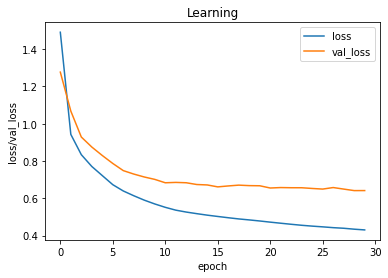

In [847]:
loss = history_gen.history['loss']
# acc = history.history['acc']
val_loss = history_gen.history['val_loss']
# val_acc = history.history['val_acc'] 
# val_iou_score = history.history['val_iou_score']
# iou_score = history.history['iou_score']
epoch = 30
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
# plt.plot(range(epoch), acc, label = "acc")
# plt.plot(range(epoch), iou_score, label = "iou_score")
# plt.plot(range(epoch), val_iou_score, label = "val_iou_score")
plt.legend()


### For 20 epochs more!

In [ ]:
 
history_gen_2 = model_attention_general.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


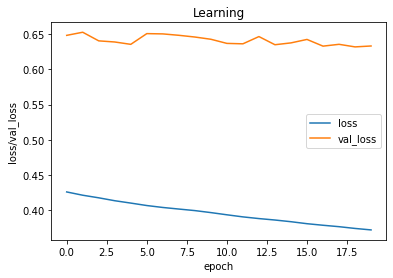

In [855]:
loss = history_gen_2.history['loss']
# acc = history.history['acc']
val_loss = history_gen_2.history['val_loss']
# val_acc = history.history['val_acc'] 
# val_iou_score = history.history['val_iou_score']
# iou_score = history.history['iou_score']
epoch = 20
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
# plt.plot(range(epoch), acc, label = "acc")
# plt.plot(range(epoch), iou_score, label = "iou_score")
# plt.plot(range(epoch), val_iou_score, label = "val_iou_score")
plt.legend()


### For 10 epochs more!

In [849]:
history_gen_3 = model_attention_general.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


Epoch 1/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3705
Epoch 1: val_loss did not improve from 0.63198
2940/2940 [==============================] - 399s 136ms/step - loss: 0.3705 - val_loss: 0.6346
Epoch 2/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3690
Epoch 2: val_loss improved from 0.63198 to 0.63049, saving model to model_save_attention_general\weights-02-0.63


INFO:tensorflow:Assets written to: model_save_attention_general\weights-02-0.63\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-02-0.63\assets


2940/2940 [==============================] - 438s 149ms/step - loss: 0.3690 - val_loss: 0.6305
Epoch 3/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3676
Epoch 3: val_loss did not improve from 0.63049
2940/2940 [==============================] - 403s 137ms/step - loss: 0.3676 - val_loss: 0.6367
Epoch 4/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3655
Epoch 4: val_loss improved from 0.63049 to 0.62991, saving model to model_save_attention_general\weights-04-0.63


INFO:tensorflow:Assets written to: model_save_attention_general\weights-04-0.63\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-04-0.63\assets


2940/2940 [==============================] - 471s 160ms/step - loss: 0.3655 - val_loss: 0.6299
Epoch 5/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3642
Epoch 5: val_loss did not improve from 0.62991
2940/2940 [==============================] - 415s 141ms/step - loss: 0.3642 - val_loss: 0.6318
Epoch 6/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3620
Epoch 6: val_loss did not improve from 0.62991
2940/2940 [==============================] - 409s 139ms/step - loss: 0.3620 - val_loss: 0.6352
Epoch 7/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3602
Epoch 7: val_loss did not improve from 0.62991
2940/2940 [==============================] - 410s 139ms/step - loss: 0.3602 - val_loss: 0.6410
Epoch 8/10
2940/2940 [==============================] - ETA: 0s - loss: 0.3588
Epoch 8: val_loss did not improve from 0.62991
2940/2940 [==============================] - 406s 138ms/step - loss: 0.3588 - val_loss: 0.6309
Epoch 9/10
2940/2940 

INFO:tensorflow:Assets written to: model_save_attention_general\weights-10-0.62\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-10-0.62\assets


2940/2940 [==============================] - 450s 153ms/step - loss: 0.3556 - val_loss: 0.6240


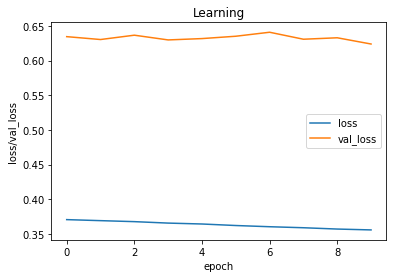

In [856]:
loss = history_gen_3.history['loss']
# acc = history.history['acc']
val_loss = history_gen_3.history['val_loss']
# val_acc = history.history['val_acc'] 
# val_iou_score = history.history['val_iou_score']
# iou_score = history.history['iou_score']
epoch = 10
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
# plt.plot(range(epoch), acc, label = "acc")
# plt.plot(range(epoch), iou_score, label = "iou_score")
# plt.plot(range(epoch), val_iou_score, label = "val_iou_score")
plt.legend()


### Now  interrupting 14/20, as its not learning anymore

In [852]:
history_gen_4 = model_attention_general.fit(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


Epoch 1/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3538
Epoch 1: val_loss did not improve from 0.62400
2940/2940 [==============================] - 413s 141ms/step - loss: 0.3538 - val_loss: 0.6345
Epoch 2/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3519
Epoch 2: val_loss did not improve from 0.62400
2940/2940 [==============================] - 407s 138ms/step - loss: 0.3519 - val_loss: 0.6241
Epoch 3/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3511
Epoch 3: val_loss did not improve from 0.62400
2940/2940 [==============================] - 427s 145ms/step - loss: 0.3511 - val_loss: 0.6266
Epoch 4/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3498
Epoch 4: val_loss did not improve from 0.62400
2940/2940 [==============================] - 415s 141ms/step - loss: 0.3498 - val_loss: 0.6395
Epoch 5/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3484
Epoch 5: val_loss did not improve fro

INFO:tensorflow:Assets written to: model_save_attention_general\weights-08-0.62\assets


INFO:tensorflow:Assets written to: model_save_attention_general\weights-08-0.62\assets


2940/2940 [==============================] - 515s 175ms/step - loss: 0.3445 - val_loss: 0.6222
Epoch 9/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3435
Epoch 9: val_loss did not improve from 0.62217
2940/2940 [==============================] - 422s 143ms/step - loss: 0.3435 - val_loss: 0.6329
Epoch 10/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3424
Epoch 10: val_loss did not improve from 0.62217
2940/2940 [==============================] - 433s 147ms/step - loss: 0.3424 - val_loss: 0.6356
Epoch 11/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3415
Epoch 11: val_loss did not improve from 0.62217
2940/2940 [==============================] - 418s 142ms/step - loss: 0.3415 - val_loss: 0.6241
Epoch 12/20
2940/2940 [==============================] - ETA: 0s - loss: 0.3405
Epoch 12: val_loss did not improve from 0.62217
2940/2940 [==============================] - 400s 136ms/step - loss: 0.3405 - val_loss: 0.6235
Epoch 13/20
294

KeyboardInterrupt: 

## BEST Loss:0.62 in 74 EPOCHS

In [62]:
def predict_gen(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    ENCODER_SEQ_LEN = 22
    DECODER_SEQ_LEN = 25
    max_len_ita = 22
    nums = tknizer_ita.texts_to_sequences([input_test_sentence])
    nums_padded = pad_sequences(nums, maxlen=max_len_ita, dtype='int32', padding='post')
    encoder_output, enc_state_h, enc_state_c = model_attention_general.layers[0](nums_padded)
    pred, alphas = [], []
    cur_vec = np.zeros((1, 1))
    osd = model_attention_general.layers[1].onestepdecoder
    for i in range(DECODER_SEQ_LEN):
        
        
        output, state_h, state_c, attention_weights, context_vector = osd(cur_vec, encoder_output, enc_state_h, enc_state_c )
        
        enc_state_h, enc_state_c = state_h, state_c
        alphas.append(attention_weights.numpy().flatten())
        
        
        cur_vec = np.reshape(np.argmax(output), (1, 1))
        print(f"at time step {i} the word is ", cur_vec)
        
        if english_dict[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec)
        
        
     
    pred_string = ""

    pred_string = " ".join([ english_dict[i[0][0]] for i in pred])
    
    print("PREDICTED STRING:",pred_string)
    
    
    plot_attention(alphas, input_sentence, pred_string)
    
    return  input_sentence, pred_string
    
            
        
    
    
    

In [54]:
import warnings
warnings.filterwarnings("ignore")

at time step 0 the word is  [[4]]
at time step 1 the word is  [[6]]
at time step 2 the word is  [[8]]
at time step 3 the word is  [[193]]
at time step 4 the word is  [[23]]
at time step 5 the word is  [[82]]
at time step 6 the word is  [[10289]]
PREDICTED STRING: tom is the father of her


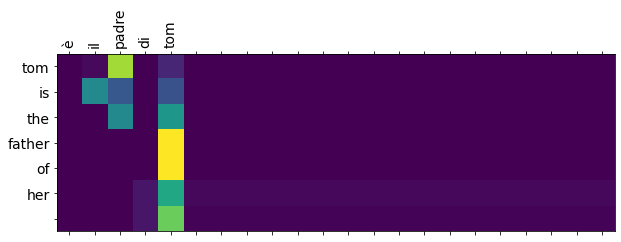

Input_sentence: è il padre di tom
English predict: tom is the father of her
English actual: that is tom is father


In [58]:
index = 200
input_test_sentence = validation["italian"].values[index]
actual = validation["english_out"].values[index]
input_sentence, pred_string = predict_gen(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {pred_string}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

In [60]:
 
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[30:60]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[30:60]
for i in range(30):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict_gen(input_test_sentence)
    print(f"ACTUAL STRING: {test_eng[i]}")
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    print(f'BL880EU score: {colored(bs, "green", attrs=["bold"]) if 0.5<=bs<=1 else colored(round(bs, 2), "red", attrs=["bold"])}')
    print("="*80)

PREDICTED STRING: she is a teacher
ACTUAL STRING: you are a teacher
BL880EU score: 0.0
PREDICTED STRING: are not you going to eat
ACTUAL STRING: are not you going to eat it
BL880EU score: 0.846481724890614
PREDICTED STRING: i would like to see up the world the world it must continue to clean myself
ACTUAL STRING: i would like to drastically decrease the amount of time it takes me to clean the house
BL880EU score: 0.19
PREDICTED STRING: i think you are right
ACTUAL STRING: i think you are selfish
BL880EU score: 0.668740304976422
PREDICTED STRING: it will be fun to have somebody to play with
ACTUAL STRING: it will be fun to have somebody to play with
BL880EU score: 1.0
PREDICTED STRING: i do not think tom
ACTUAL STRING: tell tom i do not care
BL880EU score: 0.0
PREDICTED STRING: pick up your smile
ACTUAL STRING: pick your toys up
BL880EU score: 0.0
PREDICTED STRING: tom is not interested
ACTUAL STRING: tom is not interested
BL880EU score: 1.0
PREDICTED STRING: tom and mary are not marrie

In [63]:
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[:1000]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[:1000]
bss = []
for i in tqdm(range(1000)):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict_gen(input_test_sentence)
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    bss.append(bs)


    


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 14.07it/s]


# AVG. BLUE score : 0.46

In [64]:
np.mean(bss)

0.4608461118258671

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

# MODEL-3 with concat scoring

In [65]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime

filepath="model_save_attention_concat/weights-{epoch:02d}-{val_loss:.2f}"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_format="tf", save_freq="epoch",  verbose=1, save_best_only=True, mode='auto')
           

### for 20 EPOCHS

In [66]:
 


model_attention_concat = encoder_decoder(vocab_size_ita+1,vocab_size_eng+1,22,25,512,"concat",512)
optimizer = tf.keras.optimizers.Adam()
model_attention_concat.compile(optimizer=optimizer,loss=loss_function)
train_steps=train.shape[0]//128
valid_steps=validation.shape[0]//128
history_concat = model_attention_concat.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])


Epoch 1/30
2205/2205 [==============================] - ETA: 0s - loss: 1.5441
Epoch 1: val_loss improved from inf to 1.20801, saving model to model_save_attention_concat\weights-01-1.21


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-01-1.21\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-01-1.21\assets


2205/2205 [==============================] - 523s 220ms/step - loss: 1.5441 - val_loss: 1.2080
Epoch 2/30
2205/2205 [==============================] - ETA: 0s - loss: 0.8940
Epoch 2: val_loss improved from 1.20801 to 0.95697, saving model to model_save_attention_concat\weights-02-0.96


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-02-0.96\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-02-0.96\assets


2205/2205 [==============================] - 480s 218ms/step - loss: 0.8940 - val_loss: 0.9570
Epoch 3/30
2205/2205 [==============================] - ETA: 0s - loss: 0.7229
Epoch 3: val_loss improved from 0.95697 to 0.81072, saving model to model_save_attention_concat\weights-03-0.81


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-03-0.81\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-03-0.81\assets


2205/2205 [==============================] - 480s 218ms/step - loss: 0.7229 - val_loss: 0.8107
Epoch 4/30
2205/2205 [==============================] - ETA: 0s - loss: 0.6301
Epoch 4: val_loss improved from 0.81072 to 0.71272, saving model to model_save_attention_concat\weights-04-0.71


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-04-0.71\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-04-0.71\assets


2205/2205 [==============================] - 483s 219ms/step - loss: 0.6301 - val_loss: 0.7127
Epoch 5/30
2205/2205 [==============================] - ETA: 0s - loss: 0.5602
Epoch 5: val_loss improved from 0.71272 to 0.67296, saving model to model_save_attention_concat\weights-05-0.67


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-05-0.67\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-05-0.67\assets


2205/2205 [==============================] - 481s 218ms/step - loss: 0.5602 - val_loss: 0.6730
Epoch 6/30
2205/2205 [==============================] - ETA: 0s - loss: 0.5103
Epoch 6: val_loss improved from 0.67296 to 0.63061, saving model to model_save_attention_concat\weights-06-0.63


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-06-0.63\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-06-0.63\assets


2205/2205 [==============================] - 480s 218ms/step - loss: 0.5103 - val_loss: 0.6306
Epoch 7/30
2205/2205 [==============================] - ETA: 0s - loss: 0.4715
Epoch 7: val_loss improved from 0.63061 to 0.59546, saving model to model_save_attention_concat\weights-07-0.60


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-07-0.60\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-07-0.60\assets


2205/2205 [==============================] - 482s 219ms/step - loss: 0.4715 - val_loss: 0.5955
Epoch 8/30
2205/2205 [==============================] - ETA: 0s - loss: 0.4398
Epoch 8: val_loss improved from 0.59546 to 0.57801, saving model to model_save_attention_concat\weights-08-0.58


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-08-0.58\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-08-0.58\assets


2205/2205 [==============================] - 485s 220ms/step - loss: 0.4398 - val_loss: 0.5780
Epoch 9/30
2205/2205 [==============================] - ETA: 0s - loss: 0.4145
Epoch 9: val_loss improved from 0.57801 to 0.55788, saving model to model_save_attention_concat\weights-09-0.56


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-09-0.56\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-09-0.56\assets


2205/2205 [==============================] - 482s 219ms/step - loss: 0.4145 - val_loss: 0.5579
Epoch 10/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3916
Epoch 10: val_loss improved from 0.55788 to 0.54283, saving model to model_save_attention_concat\weights-10-0.54


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-10-0.54\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-10-0.54\assets


2205/2205 [==============================] - 485s 220ms/step - loss: 0.3916 - val_loss: 0.5428
Epoch 11/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3715
Epoch 11: val_loss improved from 0.54283 to 0.52888, saving model to model_save_attention_concat\weights-11-0.53


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-11-0.53\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-11-0.53\assets


2205/2205 [==============================] - 486s 220ms/step - loss: 0.3715 - val_loss: 0.5289
Epoch 12/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3535
Epoch 12: val_loss improved from 0.52888 to 0.51814, saving model to model_save_attention_concat\weights-12-0.52


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-12-0.52\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-12-0.52\assets


2205/2205 [==============================] - 493s 224ms/step - loss: 0.3535 - val_loss: 0.5181
Epoch 13/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3374
Epoch 13: val_loss improved from 0.51814 to 0.50187, saving model to model_save_attention_concat\weights-13-0.50


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-13-0.50\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-13-0.50\assets


2205/2205 [==============================] - 489s 222ms/step - loss: 0.3374 - val_loss: 0.5019
Epoch 14/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3225
Epoch 14: val_loss did not improve from 0.50187
2205/2205 [==============================] - 454s 206ms/step - loss: 0.3225 - val_loss: 0.5073
Epoch 15/30
2205/2205 [==============================] - ETA: 0s - loss: 0.3103
Epoch 15: val_loss improved from 0.50187 to 0.49649, saving model to model_save_attention_concat\weights-15-0.50


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-15-0.50\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-15-0.50\assets


2205/2205 [==============================] - 497s 226ms/step - loss: 0.3103 - val_loss: 0.4965
Epoch 16/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2993
Epoch 16: val_loss improved from 0.49649 to 0.49440, saving model to model_save_attention_concat\weights-16-0.49


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-16-0.49\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-16-0.49\assets


2205/2205 [==============================] - 487s 221ms/step - loss: 0.2993 - val_loss: 0.4944
Epoch 17/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2898
Epoch 17: val_loss improved from 0.49440 to 0.48235, saving model to model_save_attention_concat\weights-17-0.48


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-17-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-17-0.48\assets


2205/2205 [==============================] - 490s 222ms/step - loss: 0.2898 - val_loss: 0.4824
Epoch 18/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2805
Epoch 18: val_loss did not improve from 0.48235
2205/2205 [==============================] - 446s 202ms/step - loss: 0.2805 - val_loss: 0.4940
Epoch 19/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2713
Epoch 19: val_loss improved from 0.48235 to 0.47935, saving model to model_save_attention_concat\weights-19-0.48


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-19-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-19-0.48\assets


2205/2205 [==============================] - 487s 221ms/step - loss: 0.2713 - val_loss: 0.4793
Epoch 20/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2630
Epoch 20: val_loss improved from 0.47935 to 0.47667, saving model to model_save_attention_concat\weights-20-0.48


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-20-0.48\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-20-0.48\assets


2205/2205 [==============================] - 491s 223ms/step - loss: 0.2630 - val_loss: 0.4767
Epoch 21/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2557
Epoch 21: val_loss improved from 0.47667 to 0.47429, saving model to model_save_attention_concat\weights-21-0.47


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-21-0.47\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-21-0.47\assets


2205/2205 [==============================] - 497s 226ms/step - loss: 0.2557 - val_loss: 0.4743
Epoch 22/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2488
Epoch 22: val_loss did not improve from 0.47429
2205/2205 [==============================] - 449s 204ms/step - loss: 0.2488 - val_loss: 0.4774
Epoch 23/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2426
Epoch 23: val_loss did not improve from 0.47429
2205/2205 [==============================] - 449s 204ms/step - loss: 0.2426 - val_loss: 0.4787
Epoch 24/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2372
Epoch 24: val_loss improved from 0.47429 to 0.46751, saving model to model_save_attention_concat\weights-24-0.47


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-24-0.47\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-24-0.47\assets


2205/2205 [==============================] - 490s 222ms/step - loss: 0.2372 - val_loss: 0.4675
Epoch 25/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2323
Epoch 25: val_loss improved from 0.46751 to 0.46494, saving model to model_save_attention_concat\weights-25-0.46


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-25-0.46\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-25-0.46\assets


2205/2205 [==============================] - 495s 225ms/step - loss: 0.2323 - val_loss: 0.4649
Epoch 26/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2277
Epoch 26: val_loss improved from 0.46494 to 0.45978, saving model to model_save_attention_concat\weights-26-0.46


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-26-0.46\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-26-0.46\assets


2205/2205 [==============================] - 494s 224ms/step - loss: 0.2277 - val_loss: 0.4598
Epoch 27/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2233
Epoch 27: val_loss did not improve from 0.45978
2205/2205 [==============================] - 453s 205ms/step - loss: 0.2233 - val_loss: 0.4626
Epoch 28/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2195
Epoch 28: val_loss did not improve from 0.45978
2205/2205 [==============================] - 461s 209ms/step - loss: 0.2195 - val_loss: 0.4613
Epoch 29/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2151
Epoch 29: val_loss improved from 0.45978 to 0.45379, saving model to model_save_attention_concat\weights-29-0.45


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-29-0.45\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-29-0.45\assets


2205/2205 [==============================] - 497s 226ms/step - loss: 0.2151 - val_loss: 0.4538
Epoch 30/30
2205/2205 [==============================] - ETA: 0s - loss: 0.2116
Epoch 30: val_loss did not improve from 0.45379
2205/2205 [==============================] - 453s 205ms/step - loss: 0.2116 - val_loss: 0.4549


## Learning graph

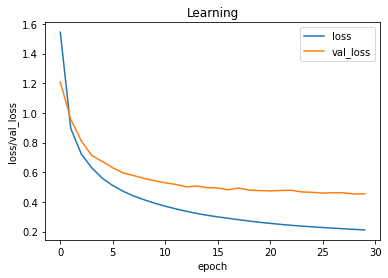

In [68]:
loss = history_concat.history['loss']
# acc = history.history['acc']
val_loss = history_concat.history['val_loss']
# val_acc = history.history['val_acc'] 
# val_iou_score = history.history['val_iou_score']
# iou_score = history.history['iou_score']
epoch = 30
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
# plt.plot(range(epoch), acc, label = "acc")
# plt.plot(range(epoch), iou_score, label = "iou_score")
# plt.plot(range(epoch), val_iou_score, label = "val_iou_score")
plt.legend()


### for 30 EPOCHS MORE!

In [67]:
history_concat_2 = model_attention_concat.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=test_dataloader, validation_steps=valid_steps,
                   callbacks=[checkpoint])

Epoch 1/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2080
Epoch 1: val_loss did not improve from 0.45379
2205/2205 [==============================] - 452s 205ms/step - loss: 0.2080 - val_loss: 0.4554
Epoch 2/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2042
Epoch 2: val_loss did not improve from 0.45379
2205/2205 [==============================] - 453s 205ms/step - loss: 0.2042 - val_loss: 0.4539
Epoch 3/10
2205/2205 [==============================] - ETA: 0s - loss: 0.2013
Epoch 3: val_loss did not improve from 0.45379
2205/2205 [==============================] - 453s 206ms/step - loss: 0.2013 - val_loss: 0.4606
Epoch 4/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1985
Epoch 4: val_loss improved from 0.45379 to 0.44704, saving model to model_save_attention_concat\weights-04-0.45


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-04-0.45\assets


INFO:tensorflow:Assets written to: model_save_attention_concat\weights-04-0.45\assets


2205/2205 [==============================] - 497s 225ms/step - loss: 0.1985 - val_loss: 0.4470
Epoch 5/10
2205/2205 [==============================] - ETA: 0s - loss: 0.1959
Epoch 5: val_loss did not improve from 0.44704
2205/2205 [==============================] - 462s 210ms/step - loss: 0.1959 - val_loss: 0.4541
Epoch 6/10
1642/2205 [=====================>........] - ETA: 1:57 - loss: 0.1920

KeyboardInterrupt: 

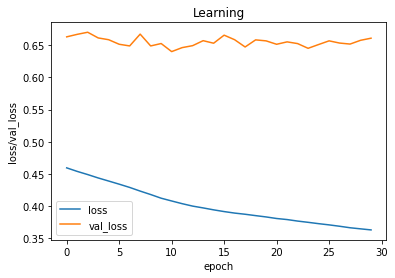

In [947]:
loss = history_concat_2.history['loss']
# acc = history.history['acc']
val_loss = history_concat_2.history['val_loss']
# val_acc = history.history['val_acc'] 
# val_iou_score = history.history['val_iou_score']
# iou_score = history.history['iou_score']
epoch = 30
plt.xlabel('epoch')
plt.ylabel('loss/val_loss')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), val_loss, label = "val_loss")
# plt.plot(range(epoch), acc, label = "acc")
# plt.plot(range(epoch), iou_score, label = "iou_score")
# plt.plot(range(epoch), val_iou_score, label = "val_iou_score")
plt.legend()


# BEST Loss:0.447 in 50 EPOCHS

In [75]:
def predict_concat(input_test_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    ENCODER_SEQ_LEN = 22
    DECODER_SEQ_LEN = 25
    max_len_ita = 22
    nums = tknizer_ita.texts_to_sequences([input_test_sentence])
    nums_padded = pad_sequences(nums, maxlen=max_len_ita, dtype='int32', padding='post')
    encoder_output, enc_state_h, enc_state_c = model_attention_concat.layers[0](nums_padded)
    pred, alphas = [], []
    cur_vec = np.zeros((1, 1))
    osd = model_attention_concat.layers[1].onestepdecoder
    for i in range(DECODER_SEQ_LEN):
        
        
        output, state_h, state_c, attention_weights, context_vector = osd(cur_vec, encoder_output, enc_state_h, enc_state_c )
        
        enc_state_h, enc_state_c = state_h, state_c
        alphas.append(attention_weights.numpy().flatten())
        
        
        cur_vec = np.reshape(np.argmax(output), (1, 1))
        print(f"at time step {i} the word is ", cur_vec)
        
        if english_dict[cur_vec[0][0]] == '<end>':
            break
        pred.append(cur_vec)
        
        
     
    pred_string = ""

    pred_string = " ".join([ english_dict[i[0][0]] for i in pred])
    
    print("PREDICTED STRING:",pred_string)
    
   
    
    plot_attention(alphas, input_test_sentence, pred_string)
    
    return  input_test_sentence, pred_string
    
            
        
    
    
    

at time step 0 the word is  [[4]]
at time step 1 the word is  [[6]]
at time step 2 the word is  [[9]]
at time step 3 the word is  [[193]]
at time step 4 the word is  [[23]]
at time step 5 the word is  [[32]]
at time step 6 the word is  [[6]]
at time step 7 the word is  [[10289]]
PREDICTED STRING: tom is a father of mary is


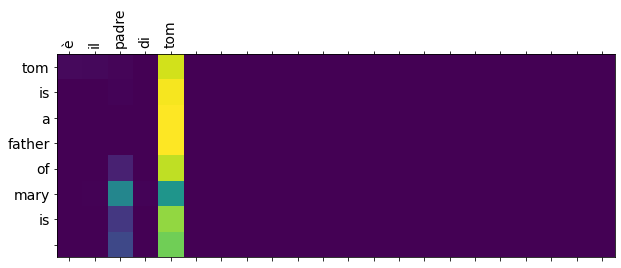

Input_sentence: è il padre di tom
English predict: tom is a father of mary is
English actual: that is tom is father


In [72]:
index = 200
input_test_sentence = validation["italian"].values[index]
actual = validation["english_out"].values[index]
input_sentence, pred_string = predict_concat(input_test_sentence)
import re
print(f"Input_sentence: {input_sentence}")
print(f"English predict: {pred_string}")
print(f"English actual: {re.sub('<end>', '', actual).strip()}")

## BLUE SCORES

In [74]:
 
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[30:60]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[30:60]
for i in range(30):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict_concat(input_test_sentence)
    print(f"ACTUAL STRING: {test_eng[i]}")
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    print(f'BL880EU score: {colored(bs, "green", attrs=["bold"]) if 0.5<=bs<=1 else colored(round(bs, 2), "red", attrs=["bold"])}')
    print("="*80)

PREDICTED STRING: she is a teacher
ACTUAL STRING: you are a teacher
BL880EU score: 0.0
PREDICTED STRING: are not you going to eat it
ACTUAL STRING: are not you going to eat it
BL880EU score: 1.0
PREDICTED STRING: i would like to leave the meat that you to sit at that time before my house
ACTUAL STRING: i would like to drastically decrease the amount of time it takes me to clean the house
BL880EU score: 0.17
PREDICTED STRING: i think you are jealous
ACTUAL STRING: i think you are selfish
BL880EU score: 0.668740304976422
PREDICTED STRING: it is going to have fun to have with to
ACTUAL STRING: it will be fun to have somebody to play with
BL880EU score: 0.0
PREDICTED STRING: tell tom he does not care
ACTUAL STRING: tell tom i do not care
BL880EU score: 0.0
PREDICTED STRING: pick up your company
ACTUAL STRING: pick your toys up
BL880EU score: 0.0
PREDICTED STRING: tom is not interested
ACTUAL STRING: tom is not interested
BL880EU score: 1.0
PREDICTED STRING: tom and mary are not canadian
AC

In [76]:
import nltk.translate.bleu_score as bleu
test_it = validation["italian"].values[:1000]
test_eng = validation["english_out"].apply(lambda a:re.sub('<end>', '', a).strip()).values[:1000]
bss = []
for i in tqdm(range(1000)):
    input_test_sentence = test_it[i]
    input_sentence, pred_string = predict_concat(input_test_sentence)
    reference = [test_eng[i].split()] # the original
    translation = pred_string.split() # trasilated using model
    bs = bleu.sentence_bleu(reference, translation)
    bss.append(bs)


    


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  8.00it/s]


# AVG. Blue scores : 0.497

In [77]:
np.mean(bss)

0.49700195512744866

In [30]:
# model_attention_general.save('model_attention_gen',save_format='tf')
# model_attention_concat.save('model_attention_concat',save_format='tf')
# model_attention_dot.save('model_attention_dot',save_format='tf')
# loaded_model1 = tf.keras.models.load_model('model_1')